In [109]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import Model
from keras.layers import Bidirectional
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import FunctionTransformer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.pipeline import Pipeline
import re
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy

In [3]:
df=pd.read_csv('C:\\Users\\Dell\\Downloads\\Telegram Desktop\\amazon_reviews_us_Digital_Video_Games_v1_00.tsv', sep='\t')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31


In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
df.dropna(axis=0)
df['review_text'] = df['review_body'].str.lower()   #Converting to Lower case
df['review_text'].head()

0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                             awesome!
Name: review_text, dtype: object

In [13]:
df['review_text'] = df['review_text'].str.replace('[^\w\s]','') #Removing punctuations
df['review_text'].head()

C:\Users\Dell\AppData\Local\Temp/ipykernel_22440/307170365.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('[^\w\s]','') #Removing punctuations


0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                              awesome
Name: review_text, dtype: object

In [14]:
df['review_text'] = df['review_text'].str.replace('\d+', '') #Removing numbers
df.dropna()
df['review_text'].head()

C:\Users\Dell\AppData\Local\Temp/ipykernel_22440/1880823837.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('\d+', '') #Removing numbers


0    i keep buying madden every year hoping they ge...
1                                              awesome
2    if you are prepping for the end of the world t...
3                                              perfect
4                                              awesome
Name: review_text, dtype: object

In [15]:
#Removing the stop words 
df = df[df['review_text'].notnull()]
stop = stopwords.words('english')
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text,bad_product
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...,1
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one things installed youren...,0
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0


In [17]:
#Creating a Target Variable with condition if the rating is less than 3, it will be a bad product otherwise not.
df['bad_product'] = 0
df.loc[df['star_rating'] <= 2, 'bad_product'] = 1
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text,bad_product
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...,1
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one things installed youren...,0
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0


In [18]:
#Lemmatization
def Lemm(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
df['review_text']= df['review_text'].apply(Lemm)
df.head(20)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_text,bad_product
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buy madden every year hope get back footb...,1
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,preppe end world one thing instal yourendofthe...,0
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0
5,US,22151364,R3CFKLIZ0I2KOB,B00IMIL498,621922192,Double Dragon: Neon [Online Game Code],Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0
6,US,38426028,R1LRYU1V0T3O38,B00S00IJH8,215163395,Sims 4,Digital_Video_Games,4,0,0,N,Y,i like the new skills like herbalism in this,"i like the new skills like herbalism in this, ...",2015-08-31,like new skill like herbalism camping fun also...,0
7,US,6057518,R44QKV6FE5CJ2,B004RMK4BC,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Super,2015-08-31,super,0
8,US,20715661,R2TX1KLPXXXNYS,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Easy & Fast,"Excellent, fast and secure!!!",2015-08-31,excellent fast secure,0
9,US,26540306,R1JEEW4C6R89BA,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Ok,2015-08-31,ok,0


In [21]:
df_final = df[["review_text","bad_product"]]

In [110]:
df_final

,review_text,bad_product
0,keep buy madden every year hope get back footb...,1
1,awesome,0
2,preppe end world one thing instal yourendofthe...,0
3,perfect,0
4,awesome,0
...,...,...
144719,worry due review see do not time wait package ...,0
144720,download christmas present kid I ve spend well...,1
144721,previous reviewer correct noting install take ...,0
144722,download son birthday yesterday intend install...,1


In [23]:
review = df_final.review_text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [111]:
with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
print(review[0])
print(encoded_docs[0])

keep buy madden every year hope get back football year version little well last year that s say muchthe game look great thing wrong animation way player always trip otherbr br gameplay still slow bloated preplay control use take two button giant pita get do opponent snap ball play clock run outbr br turbo button back player movement still slow awkward like last year version I m guess you ll like have not chance play anything train online game I m cross finger hope rest betterbr br one thing recommend buy madden bundle game come download hate there s trading gamestop
[82, 12, 2158, 87, 88, 226, 4, 73, 2038, 88, 80, 79, 13, 186, 88, 142, 58, 34, 1, 47, 11, 44, 368, 777, 31, 65, 133, 1374, 5, 100, 42, 303, 141, 23, 29, 117, 418, 1440, 4, 7, 1275, 4468, 938, 3, 1819, 51, 1564, 5, 4717, 418, 73, 65, 849, 42, 303, 2132, 6, 186, 88, 80, 14, 49, 420, 48, 170, 6, 208, 2, 555, 3, 202, 1126, 74, 1, 14, 49, 1611, 2159, 226, 666, 2137, 5, 9, 44, 68, 12, 2158, 499, 1, 62, 20, 455, 191, 58, 2166, 178

In [25]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   82   12 2158   87   88  226    4   73
 2038   88   80   79   13  186   88  142   58   34    1   47   11   44
  368  777   31   65  133 1374    5  100   42  303  141   23   29  117
  418 1440    4    7 1275 4468  938    3 1819   51 1564    5 4717  418
   73   65  849   42  303 2132    6  186   88   80   14   49  420   48
  170    6  208    2  555    3  202 1126   74    1   14   49 1611 2159
  226  666 2137    5    9   44   68   12 2158  499    1   62   20  455
  191 

In [26]:
X_re = padded_sequence
Y_re = (df_final['bad_product']).values
#Y_re=df_final.bad_product.factorize()

In [28]:
df_final.bad_product.value_counts()

0    112148
1     32574
Name: bad_product, dtype: int64

In [29]:
df_final.bad_product.value_counts()

0    112148
1     32574
Name: bad_product, dtype: int64

In [30]:
product_label = df_final.bad_product.factorize()
product_label

(array([0, 1, 1, ..., 1, 0, 1], dtype=int64),
 Int64Index([1, 0], dtype='int64'))

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_re,Y_re, test_size = 0.20, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(115777, 200) (115777,)
(28945, 200) (28945,)


In [212]:

# from imblearn.over_sampling import SMOTE
# X,Y = SMOTE().fit_resample(X_re,Y_re)

## LSTM 

In [33]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.5,recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           3024992   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3,041,643
Trainable params: 3,041,643
Non-trainable params: 0
______________________________________________

In [34]:
checkpoint = ModelCheckpoint("my_h5_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]

In [35]:
history= model.fit(X_train,Y_train,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8763
Epoch 1: saving model to my_h5_model_text.h5
2895/2895 [==============================] - 441s 152ms/step - loss: 0.2984 - accuracy: 0.8763 - val_loss: 0.2708 - val_accuracy: 0.8958
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9005
Epoch 2: saving model to my_h5_model_text.h5
2895/2895 [==============================] - 443s 153ms/step - loss: 0.2474 - accuracy: 0.9005 - val_loss: 0.2441 - val_accuracy: 0.8993
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9051
Epoch 3: saving model to my_h5_model_text.h5
2895/2895 [==============================] - 446s 154ms/step - loss: 0.2343 - accuracy: 0.9051 - val_loss: 0.2500 - val_accuracy: 0.8990
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9099
Epoch 4: saving model to my_h5_model_text.h5
2895/2895 [==========

In [36]:
#Saving the Model
model_json = model.to_json()
with open("model_h5_text.json","w") as json_file:
    json_file.write(model_json)


In [37]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h5_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h5_model_text.h5")


In [38]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 16s 17ms/step


In [39]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.902090171013992
Confusion Matrix:
 [[21034  1303]
 [ 1531  5077]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     22337
           1       0.80      0.77      0.78      6608

    accuracy                           0.90     28945
   macro avg       0.86      0.85      0.86     28945
weighted avg       0.90      0.90      0.90     28945



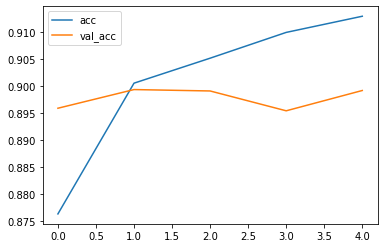

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

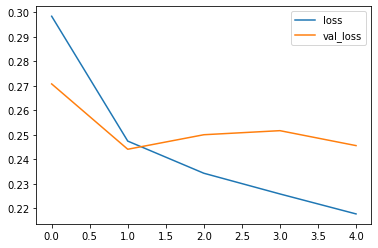

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

### Trying to balance the data to improve accuracy 

In [42]:

from imblearn.over_sampling import SMOTE
x,y = SMOTE().fit_resample(X_train,Y_train)

In [46]:
np.array(np.unique(y, return_counts=True)).T

array([[    0, 89811],
       [    1, 89811]], dtype=int64)

In [47]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.5,recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           3024992   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,041,643
Trainable params: 3,041,643
Non-trainable params: 0
____________________________________________

In [48]:
checkpoint = ModelCheckpoint("my_h5_imb_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]

In [49]:
history= model.fit(x,y,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
4491/4491 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.7933
Epoch 1: saving model to my_h5_imb_model_text.h5
4491/4491 [==============================] - 682s 151ms/step - loss: 0.4403 - accuracy: 0.7933 - val_loss: 0.6026 - val_accuracy: 0.7416
Epoch 2/5
4491/4491 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8546
Epoch 2: saving model to my_h5_imb_model_text.h5
4491/4491 [==============================] - 689s 153ms/step - loss: 0.3395 - accuracy: 0.8546 - val_loss: 0.4133 - val_accuracy: 0.8251
Epoch 3/5
4491/4491 [==============================] - ETA: 0s - loss: 0.2858 - accuracy: 0.8808
Epoch 3: saving model to my_h5_imb_model_text.h5
4491/4491 [==============================] - 688s 153ms/step - loss: 0.2858 - accuracy: 0.8808 - val_loss: 0.3490 - val_accuracy: 0.8523
Epoch 4/5
4491/4491 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8888
Epoch 4: saving model to my_h5_imb_model_text.h5
4491/

In [50]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h5_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h5_imb_model_text.h5")


In [51]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 15s 17ms/step


In [52]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8952841596130593
Confusion Matrix:
 [[21004  1333]
 [ 1698  4910]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     22337
           1       0.79      0.74      0.76      6608

    accuracy                           0.90     28945
   macro avg       0.86      0.84      0.85     28945
weighted avg       0.89      0.90      0.89     28945



#### The accuracy did not get improved much, so we are sticking to the original data

## CNN Model

In [53]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          9453100   
                                                                 
 conv1d (Conv1D)             (None, 193, 32)           25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 96, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                30730     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

In [54]:
# compile network
checkpoint = ModelCheckpoint("my_h6_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history1 = model.fit(X_train,Y_train,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8766
Epoch 1: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 337s 116ms/step - loss: 0.3145 - accuracy: 0.8766 - val_loss: 0.2777 - val_accuracy: 0.8896
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9081
Epoch 2: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 336s 116ms/step - loss: 0.2331 - accuracy: 0.9081 - val_loss: 0.2776 - val_accuracy: 0.8922
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9313
Epoch 3: saving model to my_h6_model_text.h5
2895/2895 [==============================] - 338s 117ms/step - loss: 0.1803 - accuracy: 0.9313 - val_loss: 0.2882 - val_accuracy: 0.8883
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9562
Epoch 4: saving model to my_h6_model_text.h5
2895/2895 [==========

In [55]:
#Saving the Model
model_json = model.to_json()
with open("model_h6_text.json","w") as json_file:
    json_file.write(model_json)


In [56]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h6_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h6_model_text.h5")


In [57]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 3s 4ms/step


In [58]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8761444118155122
Confusion Matrix:
 [[20471  1866]
 [ 1719  4889]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     22337
           1       0.72      0.74      0.73      6608

    accuracy                           0.88     28945
   macro avg       0.82      0.83      0.83     28945
weighted avg       0.88      0.88      0.88     28945



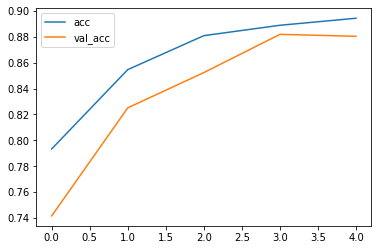

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

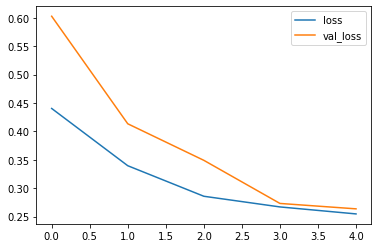

<Figure size 432x288 with 0 Axes>

In [60]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

## CNN + LSTM

In [61]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          9453100   
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 32)           9632      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 9,516,033
Trainable params: 9,516,033
Non-trainable params: 0
____________________________________________

In [62]:
# compile network
checkpoint = ModelCheckpoint("my_h7_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history2 = model.fit(X_train,Y_train,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8896
Epoch 1: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 453s 156ms/step - loss: 0.2682 - accuracy: 0.8896 - val_loss: 0.2537 - val_accuracy: 0.8989
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9132
Epoch 2: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 407s 141ms/step - loss: 0.2147 - accuracy: 0.9132 - val_loss: 0.2469 - val_accuracy: 0.8963
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9256
Epoch 3: saving model to my_h7_model_text.h5
2895/2895 [==============================] - 410s 142ms/step - loss: 0.1882 - accuracy: 0.9256 - val_loss: 0.2484 - val_accuracy: 0.9009
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9374
Epoch 4: saving model to my_h7_model_text.h5
2895/2895 [==========

In [63]:
#Saving the Model
model_json = model.to_json()
with open("model_h7_text.json","w") as json_file:
    json_file.write(model_json)


In [64]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h7_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h7_model_text.h5")


In [65]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 17s 18ms/step


In [66]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8960442217999655
Confusion Matrix:
 [[20938  1399]
 [ 1610  4998]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     22337
           1       0.78      0.76      0.77      6608

    accuracy                           0.90     28945
   macro avg       0.85      0.85      0.85     28945
weighted avg       0.89      0.90      0.90     28945



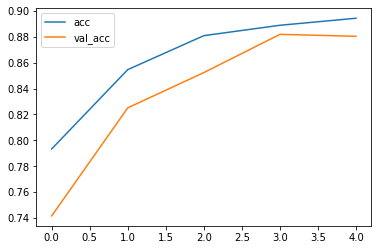

<Figure size 432x288 with 0 Axes>

In [67]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

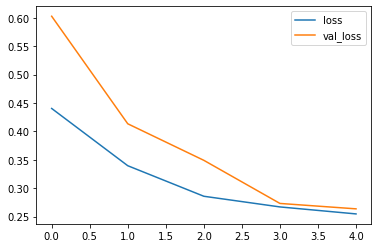

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

### Bi-LSTM 

In [100]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dense(24,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 32)           3024992   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 24)                3096      
                                                                 
 dense_14 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3,077,777
Trainable params: 3,077,777
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
# compile network
checkpoint = ModelCheckpoint("my_h8_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]
# fit network
history3 = model.fit(X_train,Y_train,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8819
Epoch 1: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 586s 201ms/step - loss: 0.2872 - accuracy: 0.8819 - val_loss: 0.2743 - val_accuracy: 0.8904
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9030
Epoch 2: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 603s 208ms/step - loss: 0.2380 - accuracy: 0.9030 - val_loss: 0.2457 - val_accuracy: 0.8997
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9097
Epoch 3: saving model to my_h8_model_text.h5
2895/2895 [==============================] - 602s 208ms/step - loss: 0.2238 - accuracy: 0.9097 - val_loss: 0.2476 - val_accuracy: 0.8991
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9135
Epoch 4: saving model to my_h8_model_text.h5
2895/2895 [==========

In [101]:
#Saving the Model
model_json = model.to_json()
with open("model_h8_text.json","w") as json_file:
    json_file.write(model_json)


In [88]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h8_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h8_model_text.h5")


In [89]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 23s 25ms/step


In [90]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.9025047503886682
Confusion Matrix:
 [[21495   842]
 [ 1980  4628]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     22337
           1       0.85      0.70      0.77      6608

    accuracy                           0.90     28945
   macro avg       0.88      0.83      0.85     28945
weighted avg       0.90      0.90      0.90     28945



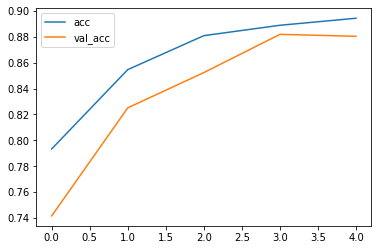

<Figure size 432x288 with 0 Axes>

In [91]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

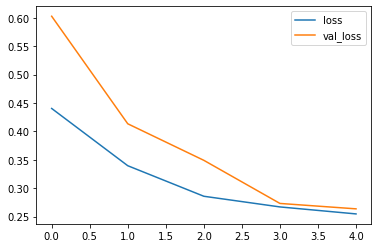

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

## CNN + Bi-LSTM

In [102]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=200))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dense(24,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 100)          9453100   
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 32)           9632      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 100, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 24)                3096      
                                                                 
 dense_16 (Dense)            (None, 1)               

In [103]:
# compile network
checkpoint = ModelCheckpoint("my_h9_model_text.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks = [checkpoint]


In [104]:
# fit network
history = model.fit(X_train,Y_train,validation_split=0.2,epochs=5,batch_size=32,callbacks=callbacks)

Epoch 1/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8876
Epoch 1: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 556s 190ms/step - loss: 0.2747 - accuracy: 0.8876 - val_loss: 0.2455 - val_accuracy: 0.8934
Epoch 2/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9099
Epoch 2: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 536s 185ms/step - loss: 0.2230 - accuracy: 0.9099 - val_loss: 0.2423 - val_accuracy: 0.9023
Epoch 3/5
2895/2895 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9182
Epoch 3: saving model to my_h9_model_text.h5
2895/2895 [==============================] - 539s 186ms/step - loss: 0.2011 - accuracy: 0.9182 - val_loss: 0.2471 - val_accuracy: 0.9015
Epoch 4/5
2895/2895 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9264
Epoch 4: saving model to my_h9_model_text.h5
2895/2895 [==========

In [105]:
#Saving the Model
model_json = model.to_json()
with open("model_h9_text.json","w") as json_file:
    json_file.write(model_json)

In [106]:
#TO open the model without training

# to open 
from keras.models import model_from_json
json_file = open('model_h9_text.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("my_h9_model_text.h5")


In [107]:
predict_x=loaded_model.predict(X_test) 


#Y_test
classes_x=np.rint(predict_x)

Y_pred = classes_x.flatten()


905/905 [==============================] - 16s 13ms/step


In [108]:
print("Accuracy-:",accuracy_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n",classification_report(Y_test,Y_pred))

Accuracy-: 0.8994990499222664
Confusion Matrix:
 [[21494   843]
 [ 2066  4542]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     22337
           1       0.84      0.69      0.76      6608

    accuracy                           0.90     28945
   macro avg       0.88      0.82      0.85     28945
weighted avg       0.90      0.90      0.90     28945



### Naive Bayes

In [69]:
from sklearn.naive_bayes import MultinomialNB

In [70]:
nb = MultinomialNB()
nb.fit(X_train,Y_train.ravel())

MultinomialNB()

In [71]:
predicted = nb.predict(X_test)

In [72]:
print("Accuracy-:",accuracy_score(Y_test,predicted))
print("Confusion Matrix:\n",confusion_matrix(Y_test, predicted))
print("Classification Report:\n",classification_report(Y_test,predicted))

Accuracy-: 0.6270858524788392
Confusion Matrix:
 [[15049  7288]
 [ 3506  3102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.74     22337
           1       0.30      0.47      0.36      6608

    accuracy                           0.63     28945
   macro avg       0.55      0.57      0.55     28945
weighted avg       0.69      0.63      0.65     28945



## Support Vector Classifier

In [73]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC()
LSVC.fit(X_train,Y_train.ravel())

C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [74]:
LSVC_pre = LSVC.predict(X_test)

In [75]:
print("Accuracy-:",accuracy_score(Y_test,LSVC_pre))
print("Confusion Matrix:\n",confusion_matrix(Y_test, LSVC_pre))
print("Classification Report:\n",classification_report(Y_test,LSVC_pre))

Accuracy-: 0.5669027465883573
Confusion Matrix:
 [[14066  8271]
 [ 4265  2343]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69     22337
           1       0.22      0.35      0.27      6608

    accuracy                           0.57     28945
   macro avg       0.49      0.49      0.48     28945
weighted avg       0.64      0.57      0.60     28945

